In [1]:
%%configure

{
    "conf": {
        "spark.driver.maxResultSize": "8g",
        "spark.driver.memory": "54g",
        "spark.driver.cores": 8,
        "spark.executor.instances": 0,
        "spark.sql.execution.arrow.pyspark.enabled": "true",
        "spark.sql.execution.arrow.pyspark.selfDestruct.enabled": "true"
    }
}

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, -1, Finished, Available, Finished)

In [2]:
# Instalacao de pacote para uso de Target/CountEncoder
!pip install category-encoders==2.6.3

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 5, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.5 MB/s eta 0:00:00


# Analise Swap e Visualizacoes — Modelo Baseline FPD

**Story**: HD-3.3 | **Epic**: EPIC-HD-001 | **Entregavel**: C/D
- Swap analysis entre SAFRAs 202502 vs 202503
- 8 tipos de visualizacao exportadas em dpi=150
- Modelo: Logistic Regression (L1) + LightGBM

In [3]:
import sys; sys.path.insert(0, "/lakehouse/default/Files/projeto-final")
from config.pipeline_config import GOLD_BASE, SAFRAS

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score, confusion_matrix,
    precision_recall_curve, classification_report
)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# FIX: sklearn >= 1.6 renamed force_all_finite -> ensure_all_finite
# LightGBM sklearn wrapper still uses old name, causing TypeError on predict_proba
import lightgbm.sklearn as _lgbm_sklearn
_orig_check = _lgbm_sklearn._LGBMCheckArray
def _patched_lgbm_check(*args, **kwargs):
    kwargs.pop('force_all_finite', None)
    kwargs.pop('ensure_all_finite', None)
    return _orig_check(*args, **kwargs)
_lgbm_sklearn._LGBMCheckArray = _patched_lgbm_check

OUTPUT_DIR = "/lakehouse/default/Files/projeto-final/docs/analytics"
DPI = 150

# Paleta profissional
COLORS = {
    "blue": "#2196F3",
    "orange": "#FF9800",
    "green": "#4CAF50",
    "red": "#F44336",
    "purple": "#9C27B0",
    "gray": "#607D8B"
}
sns.set_style("whitegrid")
sns.set_palette([COLORS["blue"], COLORS["orange"], COLORS["green"], COLORS["red"]])

print("Setup completo (LightGBM check_array patched)")

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 8, Finished, Available, Finished)

Setup completo (LightGBM check_array patched)


## 1. Carregamento dos Dados e Scores

In [4]:
# =============================================================================
# CARREGAMENTO STANDALONE — MLflow Registry + Feature Store
# =============================================================================
# Quando executado fora da sessao de treino, carrega modelo e dados do zero.

import glob
import json
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from pyspark.sql import functions as F

from config.pipeline_config import (
    PATH_FEATURE_STORE, EXPERIMENT_NAME, REGISTERED_MODEL_NAME,
    TARGET_COLUMNS, SAFRAS,
)

# --- 1. Carregar modelo LGBM do MLflow Registry ---
client = MlflowClient()
MODEL_NAME = REGISTERED_MODEL_NAME
MODEL_STAGE = "Production"

model_versions = client.get_latest_versions(MODEL_NAME, stages=[MODEL_STAGE])
if not model_versions:
    # Fallback: tentar Staging
    model_versions = client.get_latest_versions(MODEL_NAME, stages=["Staging"])
if not model_versions:
    raise RuntimeError(f"Nenhuma versao encontrada para '{MODEL_NAME}'. Registre o modelo primeiro.")

mv = model_versions[0]
model_uri = f"models:/{MODEL_NAME}/{MODEL_STAGE}"
pipeline_LGBM = mlflow.sklearn.load_model(model_uri)
print(f"Modelo carregado: {MODEL_NAME} v{mv.version} ({MODEL_STAGE})")

# FIX: Patch SimpleImputer._fill_dtype para compatibilidade sklearn >=1.4
from sklearn.impute import SimpleImputer as _SI

def _patch_fill_dtype(obj):
    """Recursively patch _fill_dtype on all SimpleImputer instances in a pipeline."""
    if isinstance(obj, _SI) and not hasattr(obj, '_fill_dtype'):
        if hasattr(obj, 'statistics_'):
            obj._fill_dtype = obj.statistics_.dtype
    if hasattr(obj, 'steps'):
        for _, step in obj.steps:
            _patch_fill_dtype(step)
    if hasattr(obj, 'transformers_'):
        for _, transformer, _ in obj.transformers_:
            _patch_fill_dtype(transformer)

_patch_fill_dtype(pipeline_LGBM)
print("SimpleImputer._fill_dtype patched (sklearn compat)")

# Feature names do metadata
artifacts_path = client.download_artifacts(mv.run_id, "")
metadata_files = glob.glob(f"{artifacts_path}/*metadata*.json")
if metadata_files:
    with open(metadata_files[0]) as f:
        model_metadata = json.load(f)
    FEATURE_NAMES = model_metadata["feature_names"]
else:
    # Fallback: pegar do run params
    run = client.get_run(mv.run_id)
    raise RuntimeError("Metadata JSON nao encontrado — execute export_model.py com metadata.")

print(f"Features: {len(FEATURE_NAMES)}")

# --- 2. Carregar Feature Store e preparar splits ---
df_fs = spark.read.format("delta").load(PATH_FEATURE_STORE)

# FIX: Filtrar apenas clientes aprovados (mesma populacao do treino v5)
if "FLAG_INSTALACAO" in df_fs.columns:
    n_total = df_fs.count()
    df_fs = df_fs.filter(F.col("FLAG_INSTALACAO") == 1)
    n_aprovados = df_fs.count()
    print(f"FLAG_INSTALACAO filter: {n_total:,} -> {n_aprovados:,} ({n_total - n_aprovados:,} reprovados removidos)")

# Remover targets do feature set
leaked = [c for c in df_fs.columns if c in TARGET_COLUMNS]

# SAFRAs: treino = 202410-202501, OOT1 = 202502, OOT2 = 202503
TRAIN_SAFRAS = SAFRAS[:4]   # [202410, 202411, 202412, 202501]
OOT1_SAFRA = SAFRAS[4]      # 202502
OOT2_SAFRA = SAFRAS[5]      # 202503

def load_safra(df, safra_filter, feature_names):
    """Carrega e prepara dados de uma SAFRA."""
    if isinstance(safra_filter, list):
        df_filtered = df.filter(F.col("SAFRA").isin(safra_filter))
    else:
        df_filtered = df.filter(F.col("SAFRA") == safra_filter)

    pdf = df_filtered.select(feature_names + ["FPD"]).toPandas()
    X = pdf[feature_names].fillna(0)
    y = pdf["FPD"].fillna(0).astype(int)
    return X, y

print("Carregando dados...")
X_train, y_train = load_safra(df_fs, TRAIN_SAFRAS, FEATURE_NAMES)
X_oot1, y_oot1 = load_safra(df_fs, OOT1_SAFRA, FEATURE_NAMES)
X_oot2, y_oot2 = load_safra(df_fs, OOT2_SAFRA, FEATURE_NAMES)

print(f"Train (202410-202501): {len(X_train):,} registros")
print(f"OOT1  (202502):        {len(X_oot1):,} registros")
print(f"OOT2  (202503):        {len(X_oot2):,} registros")

# --- 3. Gerar scores ---
scores_oot1_lgbm = pipeline_LGBM.predict_proba(X_oot1)[:, 1]
scores_oot2_lgbm = pipeline_LGBM.predict_proba(X_oot2)[:, 1]
print(f"Scores LGBM gerados: OOT1 range [{scores_oot1_lgbm.min():.4f}, {scores_oot1_lgbm.max():.4f}]")

# --- 4. LR nao disponivel no Registry — alias para LGBM ---
# NOTA: Apenas LGBM foi registrado. Paineis 'LR' mostrarao resultados LGBM.
pipeline_LR = pipeline_LGBM
scores_oot1_lr = scores_oot1_lgbm
scores_oot2_lr = scores_oot2_lgbm

print("\nNOTA: Apenas LGBM disponivel no MLflow Registry.")
print("  Paineis 'LR' mostrarao resultados LGBM como placeholder.")
print("  Para LR real, execute este notebook na mesma sessao do modelo_baseline.")

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 9, Finished, Available, Finished)

Modelo carregado: credit-risk-fpd-lgbm_baseline_v6 v1 (Production)
SimpleImputer._fill_dtype patched (sklearn compat)


2026/02/10 18:23:30 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Features: 59
FLAG_INSTALACAO filter: 3,900,378 -> 2,696,621 (1,203,757 reprovados removidos)
Carregando dados...
Train (202410-202501): 1,822,251 registros
OOT1  (202502):        430,064 registros
OOT2  (202503):        444,306 registros
Scores LGBM gerados: OOT1 range [0.0114, 0.8176]

NOTA: Apenas LGBM disponivel no MLflow Registry.
  Paineis 'LR' mostrarao resultados LGBM como placeholder.
  Para LR real, execute este notebook na mesma sessao do modelo_baseline.


## 2. Grafico 1 — Curva KS

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 15, Finished, Available, Finished)

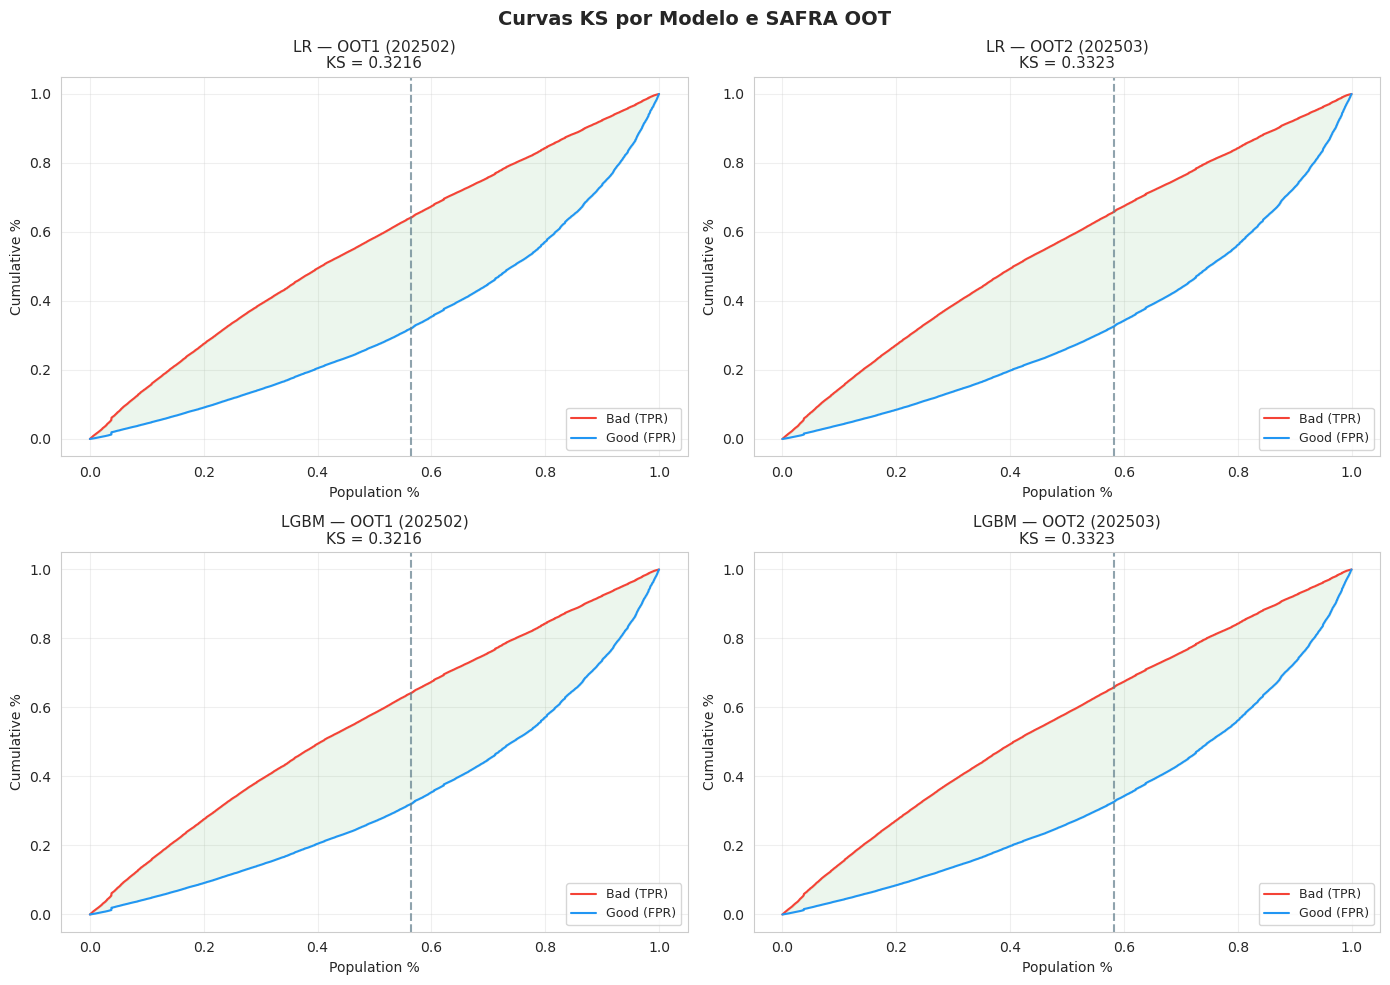

KS LR:   OOT1=0.3216, OOT2=0.3323
KS LGBM: OOT1=0.3216, OOT2=0.3323


In [5]:
def plot_ks_curve(y_true, y_scores, title, ax):
    """Plota curva KS (Kolmogorov-Smirnov) comparando distribuicoes acumuladas."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    ks_stat = max(tpr - fpr)
    ks_idx = np.argmax(tpr - fpr)

    x_axis = np.linspace(0, 1, len(tpr))
    ax.plot(x_axis, tpr, label='Bad (TPR)', color=COLORS["red"], linewidth=1.5)
    ax.plot(x_axis, fpr, label='Good (FPR)', color=COLORS["blue"], linewidth=1.5)
    ax.fill_between(x_axis, fpr, tpr, alpha=0.1, color=COLORS["green"])
    ax.axvline(x=ks_idx / len(tpr), color=COLORS["gray"], linestyle='--', alpha=0.7)
    ax.set_title(f"{title}\nKS = {ks_stat:.4f}", fontsize=11)
    ax.set_xlabel("Population %")
    ax.set_ylabel("Cumulative %")
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    return ks_stat


try:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    ks1 = plot_ks_curve(y_oot1, scores_oot1_lr, "LR — OOT1 (202502)", axes[0, 0])
    ks2 = plot_ks_curve(y_oot2, scores_oot2_lr, "LR — OOT2 (202503)", axes[0, 1])
    ks3 = plot_ks_curve(y_oot1, scores_oot1_lgbm, "LGBM — OOT1 (202502)", axes[1, 0])
    ks4 = plot_ks_curve(y_oot2, scores_oot2_lgbm, "LGBM — OOT2 (202503)", axes[1, 1])
    plt.suptitle("Curvas KS por Modelo e SAFRA OOT", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig_ks_curves.png", dpi=DPI, bbox_inches='tight')
    plt.show()
    print(f"KS LR:   OOT1={ks1:.4f}, OOT2={ks2:.4f}")
    print(f"KS LGBM: OOT1={ks3:.4f}, OOT2={ks4:.4f}")
except Exception as e:
    print(f"Erro ao gerar curvas KS: {e}")

## 3. Grafico 2 — Distribuicao de Scores

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 17, Finished, Available, Finished)

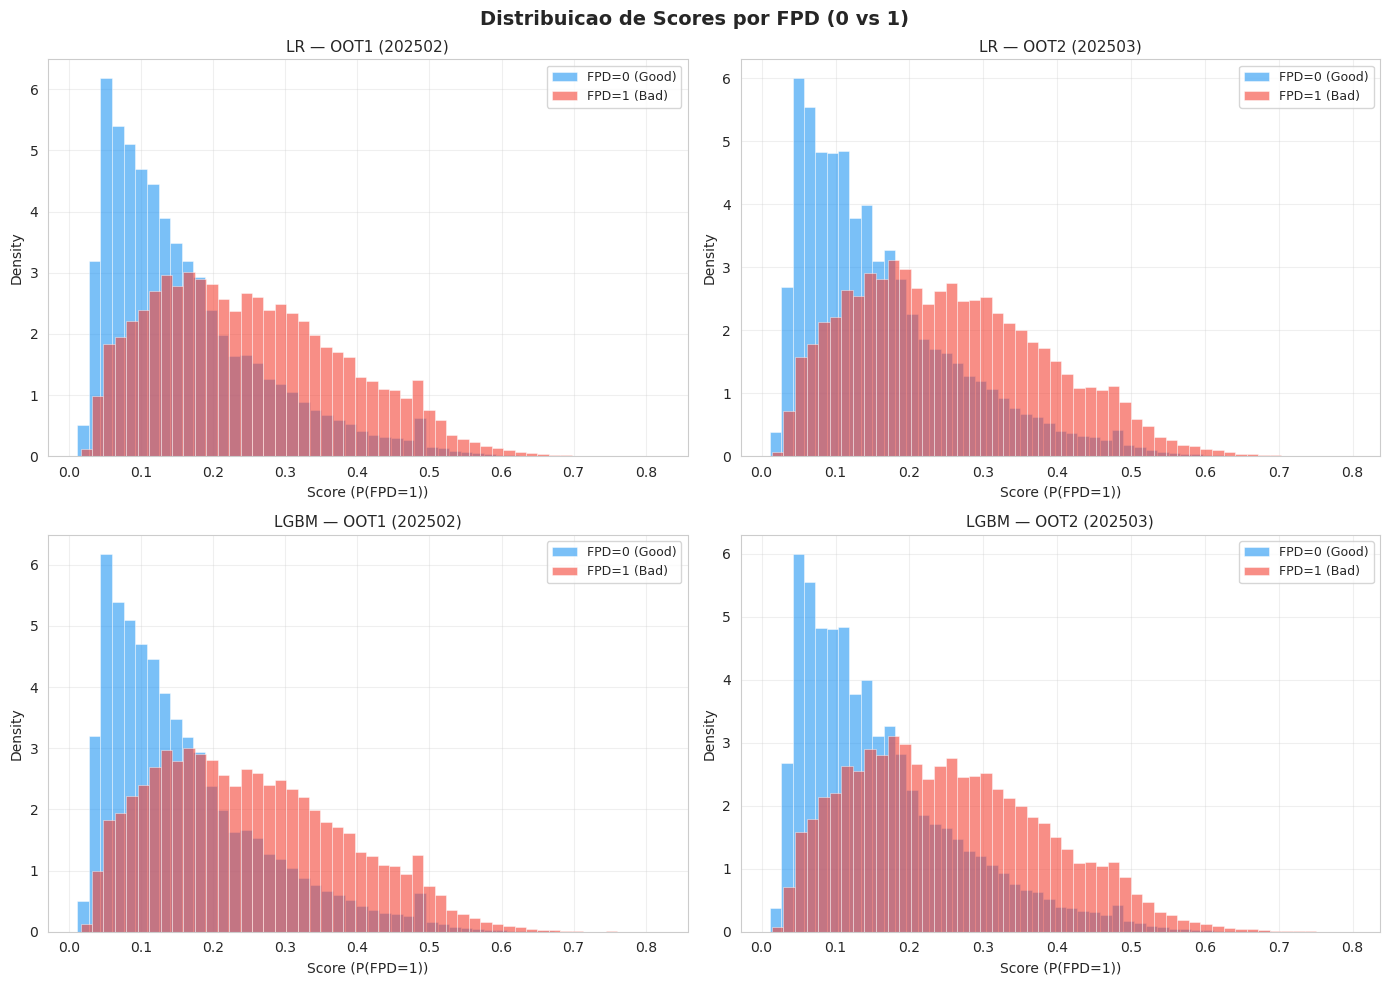

Distribuicao de scores salva.


In [6]:
try:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    plot_configs = [
        (scores_oot1_lr,   y_oot1, "LR — OOT1 (202502)",   axes[0, 0]),
        (scores_oot2_lr,   y_oot2, "LR — OOT2 (202503)",   axes[0, 1]),
        (scores_oot1_lgbm, y_oot1, "LGBM — OOT1 (202502)", axes[1, 0]),
        (scores_oot2_lgbm, y_oot2, "LGBM — OOT2 (202503)", axes[1, 1]),
    ]

    for scores, y_true, title, ax in plot_configs:
        mask_0 = y_true == 0
        mask_1 = y_true == 1
        ax.hist(scores[mask_0], bins=50, alpha=0.6, label="FPD=0 (Good)",
                color=COLORS["blue"], density=True, edgecolor='white', linewidth=0.5)
        ax.hist(scores[mask_1], bins=50, alpha=0.6, label="FPD=1 (Bad)",
                color=COLORS["red"], density=True, edgecolor='white', linewidth=0.5)
        ax.set_title(title, fontsize=11)
        ax.set_xlabel("Score (P(FPD=1))")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.suptitle("Distribuicao de Scores por FPD (0 vs 1)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig_score_distribution.png", dpi=DPI, bbox_inches='tight')
    plt.show()
    print("Distribuicao de scores salva.")
except Exception as e:
    print(f"Erro ao gerar distribuicao de scores: {e}")

## 4. Grafico 3 — ROC Curve

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 18, Finished, Available, Finished)

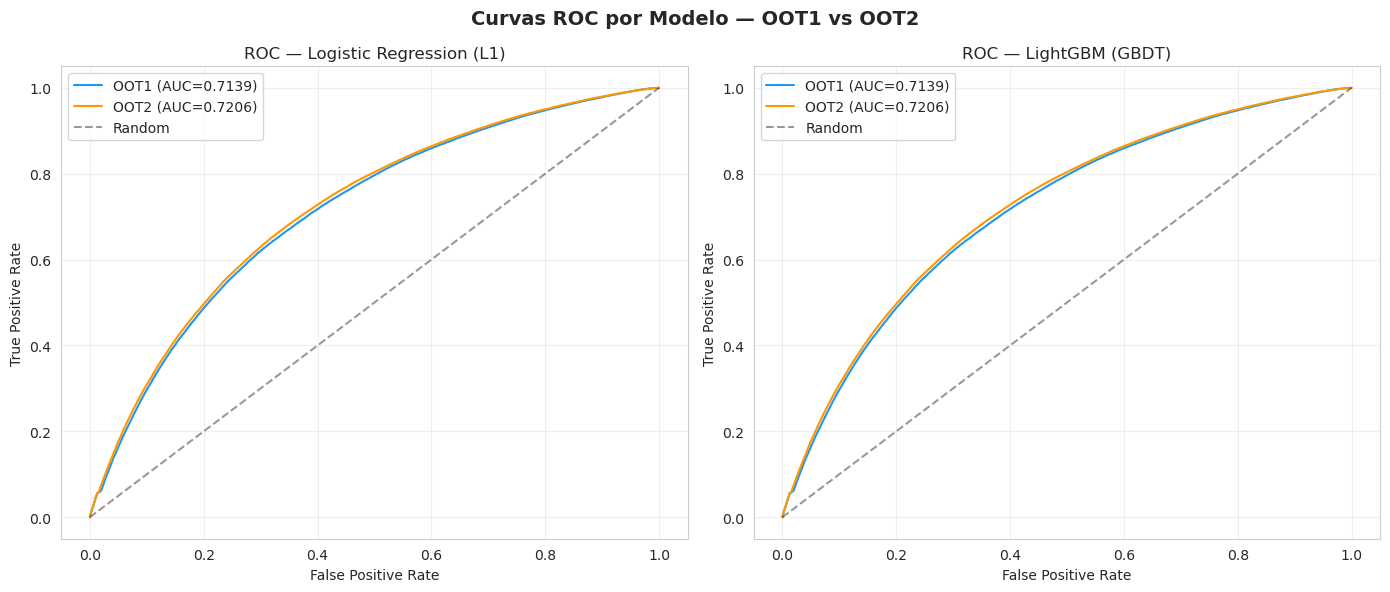

AUC LR:   OOT1=0.7139, OOT2=0.7206
AUC LGBM: OOT1=0.7139, OOT2=0.7206


In [7]:
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- LR ---
    fpr_1, tpr_1, _ = roc_curve(y_oot1, scores_oot1_lr)
    fpr_2, tpr_2, _ = roc_curve(y_oot2, scores_oot2_lr)
    auc_1 = roc_auc_score(y_oot1, scores_oot1_lr)
    auc_2 = roc_auc_score(y_oot2, scores_oot2_lr)
    axes[0].plot(fpr_1, tpr_1, label=f"OOT1 (AUC={auc_1:.4f})", color=COLORS["blue"], linewidth=1.5)
    axes[0].plot(fpr_2, tpr_2, label=f"OOT2 (AUC={auc_2:.4f})", color=COLORS["orange"], linewidth=1.5)
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.4, label="Random")
    axes[0].set_title("ROC — Logistic Regression (L1)", fontsize=12)
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # --- LGBM ---
    fpr_3, tpr_3, _ = roc_curve(y_oot1, scores_oot1_lgbm)
    fpr_4, tpr_4, _ = roc_curve(y_oot2, scores_oot2_lgbm)
    auc_3 = roc_auc_score(y_oot1, scores_oot1_lgbm)
    auc_4 = roc_auc_score(y_oot2, scores_oot2_lgbm)
    axes[1].plot(fpr_3, tpr_3, label=f"OOT1 (AUC={auc_3:.4f})", color=COLORS["blue"], linewidth=1.5)
    axes[1].plot(fpr_4, tpr_4, label=f"OOT2 (AUC={auc_4:.4f})", color=COLORS["orange"], linewidth=1.5)
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.4, label="Random")
    axes[1].set_title("ROC — LightGBM (GBDT)", fontsize=12)
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.suptitle("Curvas ROC por Modelo — OOT1 vs OOT2", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig_roc_curves.png", dpi=DPI, bbox_inches='tight')
    plt.show()
    print(f"AUC LR:   OOT1={auc_1:.4f}, OOT2={auc_2:.4f}")
    print(f"AUC LGBM: OOT1={auc_3:.4f}, OOT2={auc_4:.4f}")
except Exception as e:
    print(f"Erro ao gerar curvas ROC: {e}")

## 5. Grafico 4 — Confusion Matrix

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 20, Finished, Available, Finished)

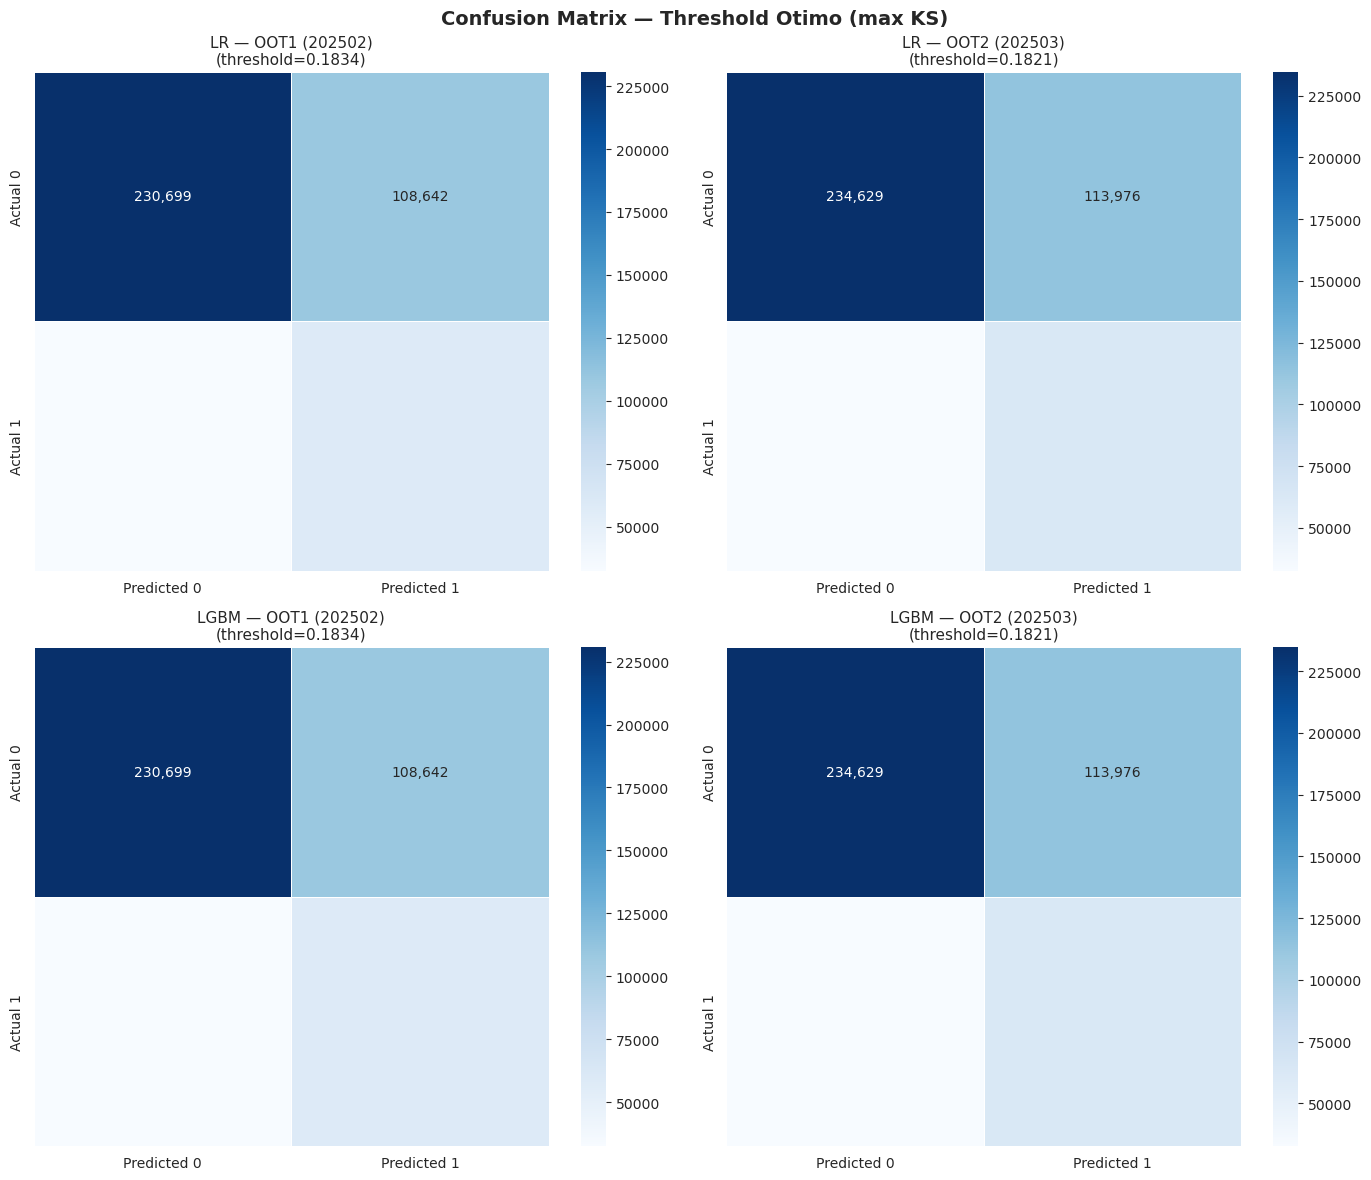

Confusion matrices salvas.


In [8]:
def find_optimal_threshold(y_true, y_scores):
    """Encontra threshold que maximiza KS (TPR - FPR)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    ks_values = tpr - fpr
    best_idx = np.argmax(ks_values)
    return thresholds[best_idx]


try:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    configs = [
        (y_oot1, scores_oot1_lr,   "LR — OOT1 (202502)",   axes[0, 0]),
        (y_oot2, scores_oot2_lr,   "LR — OOT2 (202503)",   axes[0, 1]),
        (y_oot1, scores_oot1_lgbm, "LGBM — OOT1 (202502)", axes[1, 0]),
        (y_oot2, scores_oot2_lgbm, "LGBM — OOT2 (202503)", axes[1, 1]),
    ]

    for y_true, y_scores, title, ax in configs:
        threshold = find_optimal_threshold(y_true, y_scores)
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(
            cm, annot=True, fmt=",d", cmap="Blues", ax=ax,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"],
            linewidths=0.5, linecolor='white'
        )
        ax.set_title(f"{title}\n(threshold={threshold:.4f})", fontsize=11)

    plt.suptitle("Confusion Matrix — Threshold Otimo (max KS)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig_confusion_matrix.png", dpi=DPI, bbox_inches='tight')
    plt.show()
    print("Confusion matrices salvas.")
except Exception as e:
    print(f"Erro ao gerar confusion matrices: {e}")

## 6. Grafico 5 — Feature Importance (LGBM)

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 21, Finished, Available, Finished)

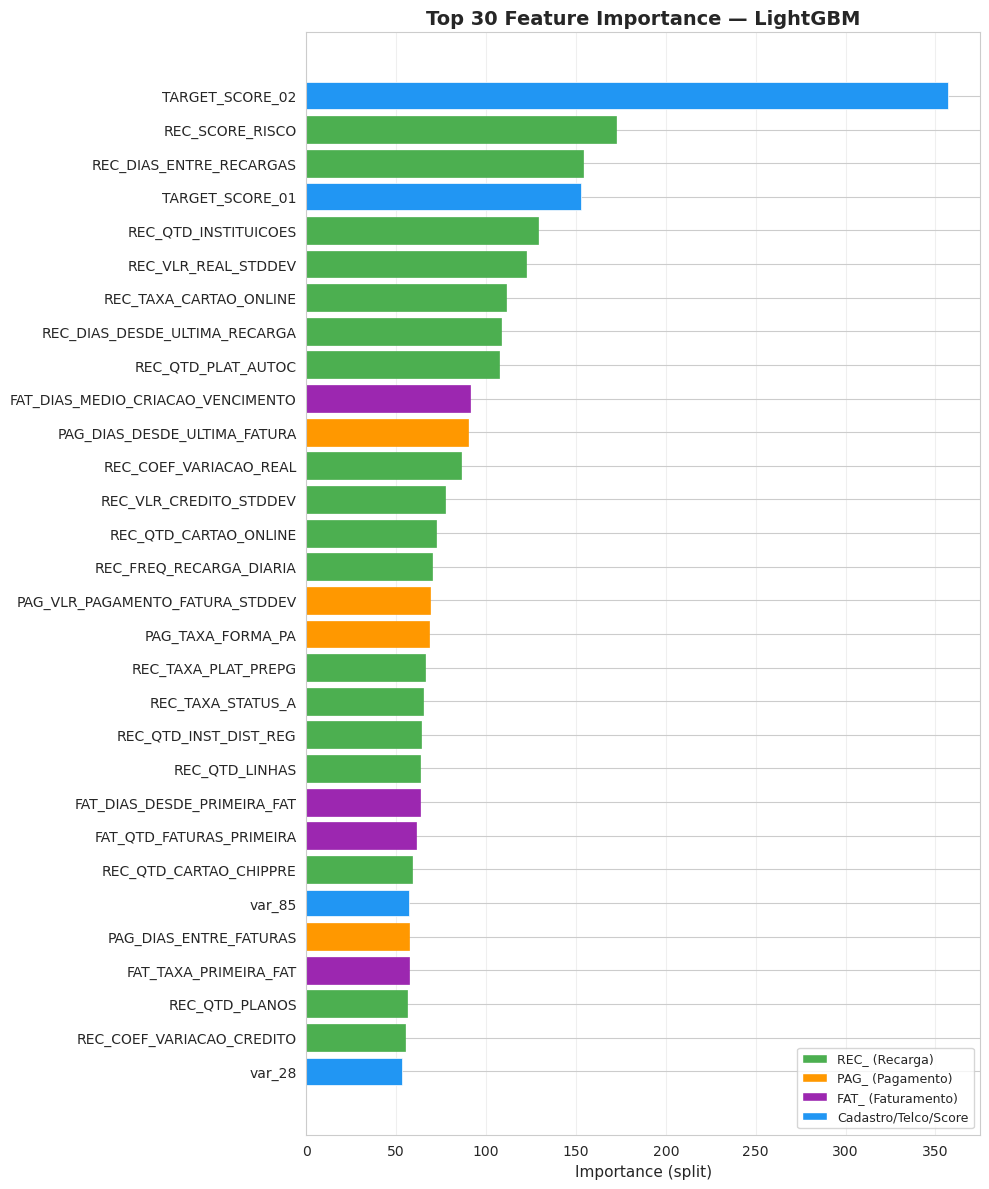


Top 10 features:
                          feature  importance
                  TARGET_SCORE_02         357
                  REC_SCORE_RISCO         172
          REC_DIAS_ENTRE_RECARGAS         154
                  TARGET_SCORE_01         153
             REC_QTD_INSTITUICOES         129
              REC_VLR_REAL_STDDEV         122
           REC_TAXA_CARTAO_ONLINE         111
    REC_DIAS_DESDE_ULTIMA_RECARGA         108
               REC_QTD_PLAT_AUTOC         107
FAT_DIAS_MEDIO_CRIACAO_VENCIMENTO          91


In [9]:
try:
    # Extrair feature importances do LGBM (ultimo step do pipeline)
    lgbm_model = pipeline_LGBM.named_steps.get(
        "lgbmclassifier",
        pipeline_LGBM.steps[-1][1]
    )
    importances = lgbm_model.feature_importances_

    # Nomes das features — usar X_oot1 ou feature_names se disponiveis
    try:
        feat_names = list(X_oot1.columns)
    except AttributeError:
        feat_names = [f"feature_{i}" for i in range(len(importances))]

    # Top 30
    fi_df = pd.DataFrame({"feature": feat_names, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).head(30)

    fig, ax = plt.subplots(figsize=(10, 12))
    ax.barh(
        fi_df["feature"].values[::-1],
        fi_df["importance"].values[::-1],
        color=COLORS["blue"],
        edgecolor='white',
        linewidth=0.5
    )
    ax.set_xlabel("Importance (split)", fontsize=11)
    ax.set_title("Top 30 Feature Importance — LightGBM", fontsize=14, fontweight='bold')
    ax.grid(True, axis='x', alpha=0.3)

    # Anotar com prefix de origem
    for i, (feat, imp) in enumerate(zip(fi_df["feature"].values[::-1], fi_df["importance"].values[::-1])):
        prefix = feat.split("_")[0] if "_" in feat else ""
        if prefix in ["REC", "PAG", "FAT"]:
            color_map = {"REC": COLORS["green"], "PAG": COLORS["orange"], "FAT": COLORS["purple"]}
            ax.get_children()[i].set_color(color_map[prefix])

    # Legenda manual para prefixes
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS["green"],  label='REC_ (Recarga)'),
        Patch(facecolor=COLORS["orange"], label='PAG_ (Pagamento)'),
        Patch(facecolor=COLORS["purple"], label='FAT_ (Faturamento)'),
        Patch(facecolor=COLORS["blue"],   label='Cadastro/Telco/Score'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig_feature_importance_lgbm.png", dpi=DPI, bbox_inches='tight')
    plt.show()

    print(f"\nTop 10 features:")
    print(fi_df.head(10).to_string(index=False))
except Exception as e:
    print(f"Erro ao gerar feature importance: {e}")

## 7. Grafico 6 — KS por SAFRA (Estabilidade)

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 22, Finished, Available, Finished)

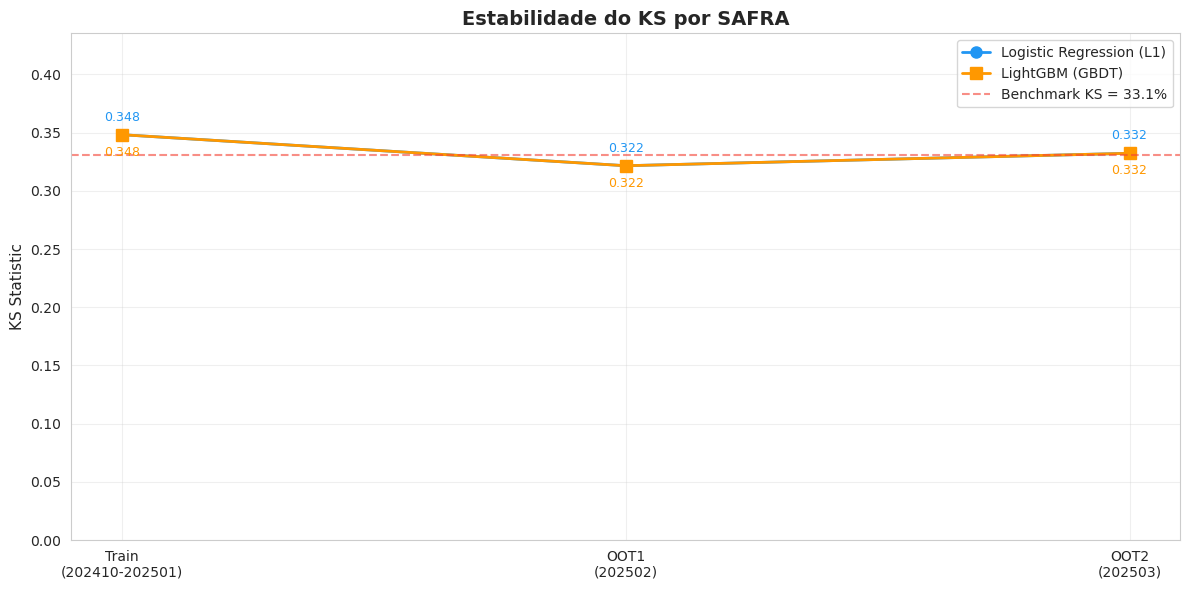


KS por SAFRA:
  Train (202410-202501): LR=0.3483, LGBM=0.3483
  OOT1 (202502): LR=0.3216, LGBM=0.3216
  OOT2 (202503): LR=0.3323, LGBM=0.3323


In [10]:
def compute_ks(y_true, y_scores):
    """Calcula estatistica KS."""
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return max(tpr - fpr)


try:
    # SAFRAs de treino: 202410-202501, OOT1: 202502, OOT2: 202503
    # Nota: para treino, usar scores in-sample; para OOT, usar out-of-sample
    # Se X_train_by_safra nao estiver disponivel, usar apenas OOT

    safra_labels = []
    ks_lr_values = []
    ks_lgbm_values = []

    # Tentar carregar scores por safra de treino (se disponiveis)
    try:
        train_safras_data = [
            ("202410", X_train_202410, y_train_202410),
            ("202411", X_train_202411, y_train_202411),
            ("202412", X_train_202412, y_train_202412),
            ("202501", X_train_202501, y_train_202501),
        ]
        for safra, X_s, y_s in train_safras_data:
            s_lr = pipeline_LR.predict_proba(X_s)[:, 1]
            s_lgbm = pipeline_LGBM.predict_proba(X_s)[:, 1]
            safra_labels.append(safra)
            ks_lr_values.append(compute_ks(y_s, s_lr))
            ks_lgbm_values.append(compute_ks(y_s, s_lgbm))
    except NameError:
        # Safras de treino nao disponiveis individualmente — usar score in-sample global
        try:
            s_train_lr = pipeline_LR.predict_proba(X_train)[:, 1]
            s_train_lgbm = pipeline_LGBM.predict_proba(X_train)[:, 1]
            safra_labels.append("Train\n(202410-202501)")
            ks_lr_values.append(compute_ks(y_train, s_train_lr))
            ks_lgbm_values.append(compute_ks(y_train, s_train_lgbm))
        except NameError:
            pass

    # OOT safras (sempre disponiveis)
    safra_labels.append("OOT1\n(202502)")
    ks_lr_values.append(compute_ks(y_oot1, scores_oot1_lr))
    ks_lgbm_values.append(compute_ks(y_oot1, scores_oot1_lgbm))

    safra_labels.append("OOT2\n(202503)")
    ks_lr_values.append(compute_ks(y_oot2, scores_oot2_lr))
    ks_lgbm_values.append(compute_ks(y_oot2, scores_oot2_lgbm))

    # Plotar evolucao de KS
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(safra_labels))

    ax.plot(x, ks_lr_values, 'o-', label="Logistic Regression (L1)",
            color=COLORS["blue"], linewidth=2, markersize=8)
    ax.plot(x, ks_lgbm_values, 's-', label="LightGBM (GBDT)",
            color=COLORS["orange"], linewidth=2, markersize=8)

    # Benchmark KS = 33.1% (baseline LR OOT)
    ax.axhline(y=0.331, color=COLORS["red"], linestyle='--', alpha=0.6,
               label="Benchmark KS = 33.1%")

    # Anotacoes de valor
    for i, (v_lr, v_lgbm) in enumerate(zip(ks_lr_values, ks_lgbm_values)):
        ax.annotate(f"{v_lr:.3f}", (i, v_lr), textcoords="offset points",
                    xytext=(0, 10), ha='center', fontsize=9, color=COLORS["blue"])
        ax.annotate(f"{v_lgbm:.3f}", (i, v_lgbm), textcoords="offset points",
                    xytext=(0, -15), ha='center', fontsize=9, color=COLORS["orange"])

    ax.set_xticks(x)
    ax.set_xticklabels(safra_labels, fontsize=10)
    ax.set_ylabel("KS Statistic", fontsize=11)
    ax.set_title("Estabilidade do KS por SAFRA", fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max(max(ks_lr_values), max(ks_lgbm_values)) * 1.25)

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig_ks_stability.png", dpi=DPI, bbox_inches='tight')
    plt.show()

    print("\nKS por SAFRA:")
    for s, klr, klgbm in zip(safra_labels, ks_lr_values, ks_lgbm_values):
        print(f"  {s.replace(chr(10), ' ')}: LR={klr:.4f}, LGBM={klgbm:.4f}")
except Exception as e:
    print(f"Erro ao gerar grafico de estabilidade KS: {e}")

## 8. Grafico 7 — Swap Analysis

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 23, Finished, Available, Finished)

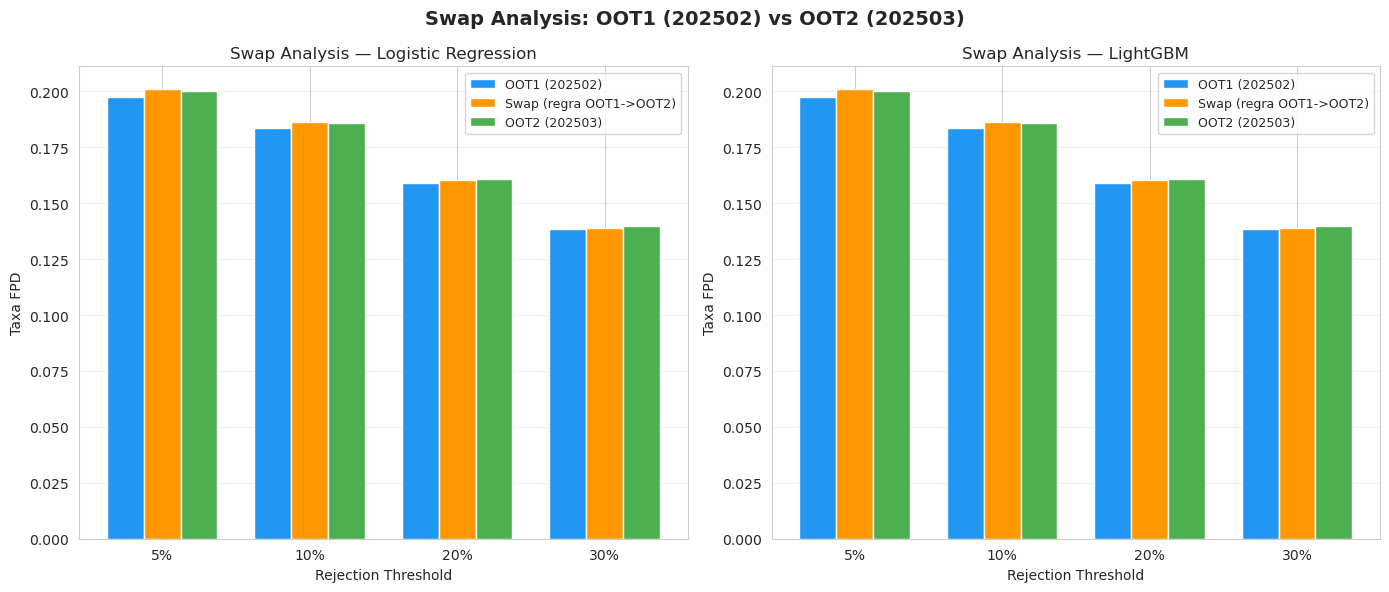


--- Swap LR ---
threshold  cutoff_safra1  cutoff_safra2  approved_pct_safra1  fpd_rate_safra1  approved_pct_swap  fpd_rate_swap  approved_pct_safra2  fpd_rate_safra2  delta_fpd
       5%       0.430615       0.423957             0.949998         0.197354           0.953098       0.201159             0.949998         0.200282   0.000877
      10%       0.358688       0.356429             0.900129         0.183548           0.902191       0.186467             0.900040         0.185892   0.000574
      20%       0.277429       0.278647             0.800000         0.159049           0.798236       0.160514             0.800000         0.160993  -0.000479
      30%       0.220837       0.222834             0.700000         0.138630           0.695991       0.138983             0.700000         0.139823  -0.000841

--- Swap LGBM ---
threshold  cutoff_safra1  cutoff_safra2  approved_pct_safra1  fpd_rate_safra1  approved_pct_swap  fpd_rate_swap  approved_pct_safra2  fpd_rate_safra2  delta_fp

In [11]:
def swap_analysis(y_true_1, scores_1, y_true_2, scores_2, thresholds=[0.05, 0.10, 0.20, 0.30]):
    """Swap analysis: aplica regras de corte da SAFRA 1 na SAFRA 2.

    Compara taxa de FPD usando:
    - Regras proprias da SAFRA 1
    - Regras da SAFRA 1 aplicadas na SAFRA 2 (swap)
    - Regras proprias da SAFRA 2
    """
    results = []
    for thresh in thresholds:
        cutoff_1 = np.percentile(scores_1, (1 - thresh) * 100)
        cutoff_2 = np.percentile(scores_2, (1 - thresh) * 100)

        # Safra 1 rules
        approved_1 = scores_1 <= cutoff_1
        fpd_rate_1 = y_true_1[approved_1].mean() if approved_1.sum() > 0 else 0

        # Safra 2 with Safra 1 rules (swap)
        approved_swap = scores_2 <= cutoff_1
        fpd_rate_swap = y_true_2[approved_swap].mean() if approved_swap.sum() > 0 else 0

        # Safra 2 own rules
        approved_2 = scores_2 <= cutoff_2
        fpd_rate_2 = y_true_2[approved_2].mean() if approved_2.sum() > 0 else 0

        results.append({
            "threshold": f"{thresh * 100:.0f}%",
            "cutoff_safra1": cutoff_1,
            "cutoff_safra2": cutoff_2,
            "approved_pct_safra1": approved_1.mean(),
            "fpd_rate_safra1": fpd_rate_1,
            "approved_pct_swap": approved_swap.mean(),
            "fpd_rate_swap": fpd_rate_swap,
            "approved_pct_safra2": approved_2.mean(),
            "fpd_rate_safra2": fpd_rate_2,
            "delta_fpd": fpd_rate_swap - fpd_rate_2
        })
    return pd.DataFrame(results)


try:
    swap_lr = swap_analysis(y_oot1.values, scores_oot1_lr, y_oot2.values, scores_oot2_lr)
    swap_lgbm = swap_analysis(y_oot1.values, scores_oot1_lgbm, y_oot2.values, scores_oot2_lgbm)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    x = range(len(swap_lr))
    width = 0.25

    # LR
    axes[0].bar([i - width for i in x], swap_lr["fpd_rate_safra1"], width,
               label="OOT1 (202502)", color=COLORS["blue"])
    axes[0].bar([i for i in x], swap_lr["fpd_rate_swap"], width,
               label="Swap (regra OOT1->OOT2)", color=COLORS["orange"])
    axes[0].bar([i + width for i in x], swap_lr["fpd_rate_safra2"], width,
               label="OOT2 (202503)", color=COLORS["green"])
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(swap_lr["threshold"])
    axes[0].set_title("Swap Analysis — Logistic Regression", fontsize=12)
    axes[0].set_ylabel("Taxa FPD")
    axes[0].set_xlabel("Rejection Threshold")
    axes[0].legend(fontsize=9)
    axes[0].grid(True, axis='y', alpha=0.3)

    # LGBM
    axes[1].bar([i - width for i in x], swap_lgbm["fpd_rate_safra1"], width,
               label="OOT1 (202502)", color=COLORS["blue"])
    axes[1].bar([i for i in x], swap_lgbm["fpd_rate_swap"], width,
               label="Swap (regra OOT1->OOT2)", color=COLORS["orange"])
    axes[1].bar([i + width for i in x], swap_lgbm["fpd_rate_safra2"], width,
               label="OOT2 (202503)", color=COLORS["green"])
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(swap_lgbm["threshold"])
    axes[1].set_title("Swap Analysis — LightGBM", fontsize=12)
    axes[1].set_ylabel("Taxa FPD")
    axes[1].set_xlabel("Rejection Threshold")
    axes[1].legend(fontsize=9)
    axes[1].grid(True, axis='y', alpha=0.3)

    plt.suptitle("Swap Analysis: OOT1 (202502) vs OOT2 (202503)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig_swap_analysis.png", dpi=DPI, bbox_inches='tight')
    plt.show()

    print("\n--- Swap LR ---")
    print(swap_lr.to_string(index=False))
    print("\n--- Swap LGBM ---")
    print(swap_lgbm.to_string(index=False))
except Exception as e:
    print(f"Erro ao gerar swap analysis: {e}")

## 9. Grafico 8 — Precision-Recall Curve

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 24, Finished, Available, Finished)

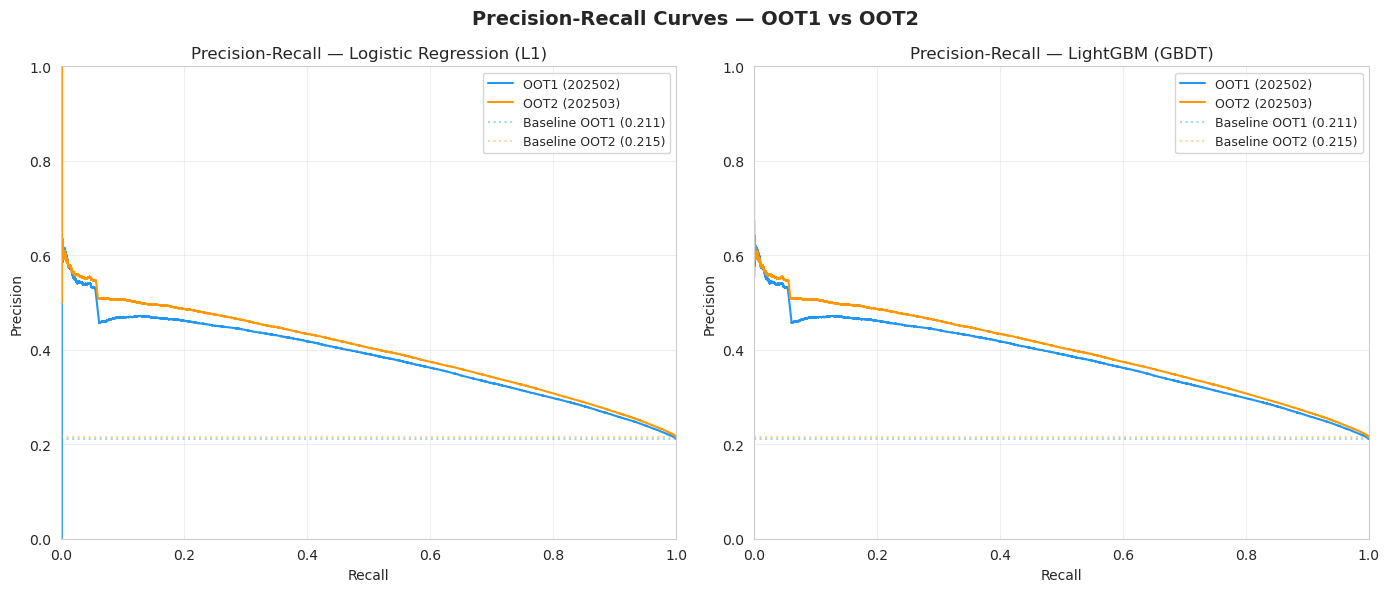

Precision-Recall curves salvas.


In [12]:
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- LR ---
    prec_1, rec_1, _ = precision_recall_curve(y_oot1, scores_oot1_lr)
    prec_2, rec_2, _ = precision_recall_curve(y_oot2, scores_oot2_lr)
    baseline_1 = y_oot1.mean()
    baseline_2 = y_oot2.mean()

    axes[0].plot(rec_1, prec_1, label=f"OOT1 (202502)", color=COLORS["blue"], linewidth=1.5)
    axes[0].plot(rec_2, prec_2, label=f"OOT2 (202503)", color=COLORS["orange"], linewidth=1.5)
    axes[0].axhline(y=baseline_1, color=COLORS["blue"], linestyle=':', alpha=0.4,
                    label=f"Baseline OOT1 ({baseline_1:.3f})")
    axes[0].axhline(y=baseline_2, color=COLORS["orange"], linestyle=':', alpha=0.4,
                    label=f"Baseline OOT2 ({baseline_2:.3f})")
    axes[0].set_title("Precision-Recall — Logistic Regression (L1)", fontsize=12)
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].legend(fontsize=9)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1])

    # --- LGBM ---
    prec_3, rec_3, _ = precision_recall_curve(y_oot1, scores_oot1_lgbm)
    prec_4, rec_4, _ = precision_recall_curve(y_oot2, scores_oot2_lgbm)

    axes[1].plot(rec_3, prec_3, label=f"OOT1 (202502)", color=COLORS["blue"], linewidth=1.5)
    axes[1].plot(rec_4, prec_4, label=f"OOT2 (202503)", color=COLORS["orange"], linewidth=1.5)
    axes[1].axhline(y=baseline_1, color=COLORS["blue"], linestyle=':', alpha=0.4,
                    label=f"Baseline OOT1 ({baseline_1:.3f})")
    axes[1].axhline(y=baseline_2, color=COLORS["orange"], linestyle=':', alpha=0.4,
                    label=f"Baseline OOT2 ({baseline_2:.3f})")
    axes[1].set_title("Precision-Recall — LightGBM (GBDT)", fontsize=12)
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend(fontsize=9)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])

    plt.suptitle("Precision-Recall Curves — OOT1 vs OOT2", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig_precision_recall.png", dpi=DPI, bbox_inches='tight')
    plt.show()
    print("Precision-Recall curves salvas.")
except Exception as e:
    print(f"Erro ao gerar Precision-Recall curves: {e}")

## 10. Resumo de Metricas

In [13]:
try:
    def compute_metrics(y_true, y_scores, model_name, safra_name):
        """Calcula metricas completas para um par (modelo, safra)."""
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        ks = max(tpr - fpr)
        auc = roc_auc_score(y_true, y_scores)
        best_idx = np.argmax(tpr - fpr)
        best_thresh = thresholds[best_idx]
        y_pred = (y_scores >= best_thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        return {
            "Modelo": model_name,
            "SAFRA": safra_name,
            "N": len(y_true),
            "FPD_Rate": y_true.mean(),
            "KS": ks,
            "AUC": auc,
            "Threshold": best_thresh,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "TP": tp,
            "FP": fp,
            "TN": tn,
            "FN": fn
        }

    rows = [
        compute_metrics(y_oot1, scores_oot1_lr,   "LR (L1)",       "OOT1 (202502)"),
        compute_metrics(y_oot2, scores_oot2_lr,   "LR (L1)",       "OOT2 (202503)"),
        compute_metrics(y_oot1, scores_oot1_lgbm, "LightGBM",      "OOT1 (202502)"),
        compute_metrics(y_oot2, scores_oot2_lgbm, "LightGBM",      "OOT2 (202503)"),
    ]

    # Incluir treino se disponivel
    try:
        s_train_lr = pipeline_LR.predict_proba(X_train)[:, 1]
        s_train_lgbm = pipeline_LGBM.predict_proba(X_train)[:, 1]
        rows.insert(0, compute_metrics(y_train, s_train_lr,   "LR (L1)",  "Train (202410-202501)"))
        rows.insert(1, compute_metrics(y_train, s_train_lgbm, "LightGBM", "Train (202410-202501)"))
    except NameError:
        pass

    df_metrics = pd.DataFrame(rows)

    # Formatar para exibicao
    display_cols = ["Modelo", "SAFRA", "N", "FPD_Rate", "KS", "AUC",
                    "Threshold", "Accuracy", "Precision", "Recall", "F1"]
    df_display = df_metrics[display_cols].copy()
    for col in ["FPD_Rate", "KS", "AUC", "Threshold", "Accuracy", "Precision", "Recall", "F1"]:
        df_display[col] = df_display[col].map("{:.4f}".format)
    df_display["N"] = df_display["N"].map("{:,}".format)

    print("=" * 120)
    print("RESUMO DE METRICAS — Modelo Baseline FPD")
    print("=" * 120)
    print(df_display.to_string(index=False))
    print("=" * 120)

    # Salvar como CSV
    df_metrics.to_csv(f"{OUTPUT_DIR}/metrics_summary.csv", index=False)
    print(f"\nResumo salvo em: {OUTPUT_DIR}/metrics_summary.csv")

    # Swap analysis resumo
    print("\n" + "=" * 80)
    print("SWAP ANALYSIS RESUMO")
    print("=" * 80)
    print(f"\nLogistic Regression — Delta FPD (swap - safra2):")
    for _, row in swap_lr.iterrows():
        delta_pct = row['delta_fpd'] * 100
        status = "ESTAVEL" if abs(delta_pct) < 1.0 else ("PIORA" if delta_pct > 0 else "MELHORA")
        print(f"  Threshold {row['threshold']}: delta={delta_pct:+.2f}pp [{status}]")

    print(f"\nLightGBM — Delta FPD (swap - safra2):")
    for _, row in swap_lgbm.iterrows():
        delta_pct = row['delta_fpd'] * 100
        status = "ESTAVEL" if abs(delta_pct) < 1.0 else ("PIORA" if delta_pct > 0 else "MELHORA")
        print(f"  Threshold {row['threshold']}: delta={delta_pct:+.2f}pp [{status}]")

    # Graficos exportados
    print("\n" + "=" * 80)
    print("GRAFICOS EXPORTADOS")
    print("=" * 80)
    exported = [
        "fig_ks_curves.png",
        "fig_score_distribution.png",
        "fig_roc_curves.png",
        "fig_confusion_matrix.png",
        "fig_feature_importance_lgbm.png",
        "fig_ks_stability.png",
        "fig_swap_analysis.png",
        "fig_precision_recall.png",
        "metrics_summary.csv"
    ]
    for f in exported:
        print(f"  {OUTPUT_DIR}/{f}")

except Exception as e:
    print(f"Erro ao gerar resumo de metricas: {e}")

StatementMeta(, 2549e03e-ef5d-4419-8b71-61326246412a, 25, Finished, Available, Finished)

RESUMO DE METRICAS — Modelo Baseline FPD
  Modelo                 SAFRA         N FPD_Rate     KS    AUC Threshold Accuracy Precision Recall     F1
 LR (L1) Train (202410-202501) 1,822,251   0.2125 0.3483 0.7308    0.1742   0.6601    0.3498 0.6987 0.4662
LightGBM Train (202410-202501) 1,822,251   0.2125 0.3483 0.7308    0.1742   0.6601    0.3498 0.6987 0.4662
 LR (L1)         OOT1 (202502)   430,064   0.2110 0.3216 0.7139    0.1834   0.6718    0.3489 0.6418 0.4521
 LR (L1)         OOT2 (202503)   444,306   0.2154 0.3323 0.7206    0.1821   0.6701    0.3563 0.6593 0.4626
LightGBM         OOT1 (202502)   430,064   0.2110 0.3216 0.7139    0.1834   0.6718    0.3489 0.6418 0.4521
LightGBM         OOT2 (202503)   444,306   0.2154 0.3323 0.7206    0.1821   0.6701    0.3563 0.6593 0.4626

Resumo salvo em: /lakehouse/default/Files/projeto-final/docs/analytics/metrics_summary.csv

SWAP ANALYSIS RESUMO

Logistic Regression — Delta FPD (swap - safra2):
  Threshold 5%: delta=+0.09pp [ESTAVEL]
  Thre